# LLM - Detect AI Generated Text
## Import

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import word2vec
from gensim.models import doc2vec
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import keras

[nltk_data] Downloading package punkt to /home/mrtc101/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtc101/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-01-06 19:09:39.809331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 19:09:39.809433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 19:09:39.810894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 19:09:39.818264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary

In [2]:
initial_dataset = pd.read_csv("../../data/train_essays.csv")
prompts_dataset = pd.read_csv("../../data/train_prompts.csv")
new_data = pd.read_csv("../../data/new_essays_V1.csv")
test_dataset = pd.read_csv("../../data/test_essays.csv")

## Data analisis

In [3]:
initial_dataset

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [4]:
initial_dataset.dtypes

id           object
prompt_id     int64
text         object
generated     int64
dtype: object

In [5]:
initial_dataset.shape

(1378, 4)

In [6]:
initial_dataset.describe()

,prompt_id,generated
count,1378.000000,1378.000000
mean,0.486212,0.002177
std,0.499991,0.046625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


`generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

In [7]:
initial_dataset.value_counts("generated")

generated
0    1375
1       3
Name: count, dtype: int64

In [8]:
generated = initial_dataset.value_counts("generated")
generated

generated
0    1375
1       3
Name: count, dtype: int64

In [9]:
generated = generated.apply(lambda x : x/initial_dataset.shape[0])
generated

generated
0    0.997823
1    0.002177
Name: count, dtype: float64

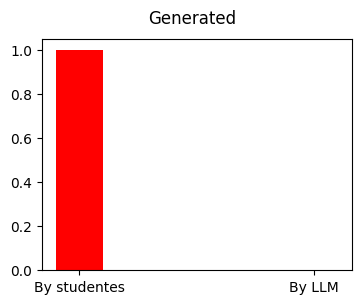

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
fig.suptitle("Generated")
ax.bar(
    x=["By studentes","By LLM"],
    height=generated,
    width=0.2,
    color=["red","green"],
    align="center")
plt.show()

In [11]:
prompts_dataset

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [12]:
prompts = initial_dataset.value_counts("prompt_id")
prompts

prompt_id
0    708
1    670
Name: count, dtype: int64

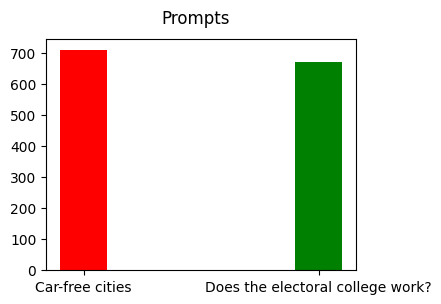

In [13]:
fig, ax = plt.subplots(figsize=(4,3))
fig.suptitle("Prompts")
ax.bar(
    x=["Car-free cities","Does the electoral college work?"],
    height=prompts,
    width=0.2,
    color=["red","green"],
    align="center")
plt.show()

In [14]:
print(initial_dataset.shape)
initial_dataset.drop_duplicates(subset=["text"],inplace=True)
initial_dataset.reset_index(drop=True, inplace=True)
print(initial_dataset.shape)

(1378, 4)
(1378, 4)


## Handle imbalanced Data

> Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like ROC area under curve. This is
the foundational challenge of imbalanced classification.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> If we think about feature space spatially, we might like all examples in one class to be located on one part
of the space, and those from the other class to appear in another part of the space. [...]
>This is rarely the case, and it is more likely that each class has multiple **concepts** resulting in multiple different groups or clusters of examples in feature space.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


### Metrics for Imbalanced Data

>Although widely used, classification accuracy is almost universally inappropriate for imbalanced classification. The reason is, a high accuracy (or low error) is achievable by a no skill model that only predicts the majority class. [...]
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>There are two groups of metrics that may be useful for imbalanced classification because they focus on one class; they are sensitivity-specificity and precision-recall.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>One limitation of these metrics is that they assume that the class distribution observed in the training dataset will match the distribution in the test set and in real data when the model is used to make predictions. [...] Ranking metrics don’t make any assumptions about class distributions.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>The most commonly used ranking metric is the ROC Curve or ROC Analysis. ROC is an
acronym that means Receiver Operating Characteristic and summarizes a field of study for
analyzing binary classifiers based on their ability to discriminate classes.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small.
An alternative to the ROC Curve is the precision-recall curve that can be used in a similar way, although focuses on the performance of the classifier on the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


#### ROC AUC curve

In [15]:
def ROCplot(model,x_val,y_val):
    #define metrics
    y_pred = model.predict(x_val).ravel()
    fpr, tpr, _ = roc_curve(y_val,  y_pred)
    aucVal = auc(fpr, tpr)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(aucVal))
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Data Sampling for imbalanced data

> Sadly, k-fold cross-validation is not appropriate for evaluating imbalanced classifiers.
[...]
The reason is that the data is split into k-folds with a uniform probability distribution. This might work fine for data with a balanced class distribution, but when the distribution is severely skewed, it is likely that one or more folds will have few or no examples from the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> The solution is to not split the data randomly when using k-fold cross-validation or a train-test
split. [...] For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> Sampling is only performed on the training dataset, the dataset used by an algorithm to
learn a model. It is not performed on the holdout test or validation dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

- Stratified k-folding CrossValidation
- Random Downsampling
- Adding data as kind of Oversampling

#### Adding new Data

Describing the imbalance of this dataset in terms of ration is 1:500. The dataset presents sever imbalance. By adding new data to the training set with text generated by ChatGPT 3, i desire to make it become near (1:100). To achieve this i need to add **10** generated text to the dataset.

This will modify the true distribution from the real dataset, but only 3 element in the minority class is not enough to apply stratified 10-fold cross validation.

In [16]:
target_data = pd.concat([initial_dataset,new_data],ignore_index=True)
target_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1395,17,0,Limiting car usage stands as a pivotal strateg...,1
1396,18,1,"\nJohn Smith\n123 Main Street\nCityville, Stat...",1
1397,19,1,"Dear Senator,\n\nI am writing to express my op...",1
1398,18,0,\nThe advantages of limiting car usage are num...,1


## Data Feature Engineering

### Training a Tokenizer
Reading the competition discussions lead me to this [Notebook](https://www.kaggle.com/code/datafan07/train-your-own-tokenizer), where is suggested to add words with typos into the vocabulary for better performance by training a tokenizer.

1. normalization
2. pre-tokenization
3. model
4. post-processing

In [17]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast


/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>ByteLevel: 
>
>Splits on whitespaces while remapping all the bytes to a set of visible characters. This technique as been introduced by OpenAI with GPT-2 and has some more or less nice properties:
> - Since it maps on bytes, a tokenizer using this only requires 256 characters as initial alphabet (the number of values a byte can have), as opposed to the 130,000+ Unicode characters.
> - A consequence of the previous point is that it is absolutely unnecessary to have an unknown token using this since we can represent anything with 256 tokens (Youhou!! 🎉🎉)
> - For non ascii characters, it gets completely unreadable, but it works nonetheless!

In [18]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
#Cleaning
raw_tokenizer.normalizer =  normalizers.Sequence(
    [
        normalizers.NFC(),
        normalizers.Lowercase(),
        normalizers.Replace("\n"," "),
        normalizers.Replace("\r"," "),
        normalizers.Replace("\t"," ")
    ]    
    )
#First tokenization
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
#Training
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(show_progress=True,special_tokens=special_tokens)

def data_iter(dataset):
    """
    A generator function for iterating over a dataset in chunks.
    """    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

raw_tokenizer.train_from_iterator(data_iter(target_data),trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [19]:
raw_tokenizer.normalizer.normalize_str("Martín's bag")

"martín's bag"

In [20]:
tokenizer.tokenize("Martín's bag")

['Ġmart', '[UNK]', '[UNK]', 'n', "'s", 'Ġbag']

##### Words Tokenizing

In [21]:
tokenized_test = test_dataset;
tokenized_test["text"] = test_dataset["text"].apply(lambda x : tokenizer.tokenize(text=x))

tokenized_dataset = target_data.copy()
tokenized_dataset["text"] = target_data["text"].apply(lambda x : tokenizer.tokenize(x))
tokenized_dataset

,id,prompt_id,text,generated
0,0059830c,0,"[Ġcars, ., Ġcars, Ġhave, Ġbeen, Ġaround, Ġsinc...",0
1,005db917,0,"[Ġtransportation, Ġis, Ġa, Ġlarge, Ġnecessity,...",0
2,008f63e3,0,"[Ġ"", america, 's, Ġlove, Ġaffair, Ġwith, Ġit, ...",0
3,00940276,0,"[Ġhow, Ġoften, Ġdo, Ġyou, Ġride, Ġin, Ġa, Ġcar...",0
4,00c39458,0,"[Ġcars, Ġare, Ġa, Ġwonderful, Ġthing, ., Ġthey...",0
...,...,...,...,...
1395,17,0,"[Ġlimiting, Ġcar, Ġusage, Ġstands, Ġas, Ġa, Ġp...",1
1396,18,1,"[Ġjohn, Ġsmith, Ġ123, Ġmain, Ġstreet, Ġcityvil...",1
1397,19,1,"[Ġdear, Ġsenator, ,, Ġ, Ġi, Ġam, Ġwriting, Ġto...",1
1398,18,0,"[Ġthe, Ġadvantages, Ġof, Ġlimiting, Ġcar, Ġusa...",1


#### Text to document embeddings

Need to add all the test documents to the training phase of embedding.

In [22]:
doc_test_dataset = test_dataset
doc_test_dataset["text"] = [doc2vec.TaggedDocument(row[2],[row[0]]) for row in tokenized_test.values]

In [23]:
docs_dataset = tokenized_dataset.copy()
docs_dataset["text"] = [doc2vec.TaggedDocument(row[2],[row[0]]) for row in tokenized_dataset.values]
docs_dataset["text"]

0       ([Ġcars, ., Ġcars, Ġhave, Ġbeen, Ġaround, Ġsin...
1       ([Ġtransportation, Ġis, Ġa, Ġlarge, Ġnecessity...
2       ([Ġ", america, 's, Ġlove, Ġaffair, Ġwith, Ġit,...
3       ([Ġhow, Ġoften, Ġdo, Ġyou, Ġride, Ġin, Ġa, Ġca...
4       ([Ġcars, Ġare, Ġa, Ġwonderful, Ġthing, ., Ġthe...
                              ...                        
1395    ([Ġlimiting, Ġcar, Ġusage, Ġstands, Ġas, Ġa, Ġ...
1396    ([Ġjohn, Ġsmith, Ġ123, Ġmain, Ġstreet, Ġcityvi...
1397    ([Ġdear, Ġsenator, ,, Ġ, Ġi, Ġam, Ġwriting, Ġt...
1398    ([Ġthe, Ġadvantages, Ġof, Ġlimiting, Ġcar, Ġus...
1399    ([Ġthe, Ġincreasing, Ġtrend, Ġtowards, Ġlimiti...
Name: text, Length: 1400, dtype: object

In [24]:
docs = pd.concat([docs_dataset["text"],doc_test_dataset["text"]])
doc_model = doc2vec.Doc2Vec(documents=docs,vector_size=100)
doc_model.train(docs,total_examples=tokenized_dataset.shape[0],epochs=10)

In [25]:
doc_model.dv[0]

array([-5.2308156e-03, -5.9791268e-03, -9.8807542e-03,  8.5528456e-03,
        3.5661161e-03,  2.6303172e-04, -9.8806275e-03, -5.1666484e-03,
       -9.7179627e-03,  2.0107795e-03,  2.8303110e-03,  4.6435557e-03,
       -4.2972756e-03, -3.1457066e-03, -3.0787874e-03, -8.7219151e-03,
        2.1724831e-03,  9.2256228e-03, -9.5018670e-03, -3.4580862e-03,
       -3.7699090e-03,  2.6073826e-03, -5.6915567e-03,  2.6206803e-03,
        5.8025215e-03, -8.1068603e-03, -8.3297910e-03, -9.9546695e-03,
        4.9330448e-03, -9.1223074e-03,  5.8419635e-03,  6.8002627e-03,
       -6.5064002e-03, -4.5198812e-03, -1.2548614e-03,  1.6463208e-03,
       -1.4813376e-03, -8.5425414e-03, -3.6026132e-03,  1.7316258e-03,
       -2.0569193e-03, -7.2300420e-03,  4.1846000e-03, -8.5743405e-03,
        2.7115368e-03, -4.6137203e-03,  6.4542773e-04, -2.0573472e-03,
        5.4132282e-03, -8.0025708e-03, -2.1198511e-03, -9.5815660e-05,
       -6.6387774e-03, -6.5261638e-03, -1.9329584e-03,  8.8034747e-03,
      

In [26]:
arr = [doc_model.dv[doc_test_dataset["text"][index].tags] for index in range (0,doc_test_dataset.shape[0])]
embeddings_test_dataset = pd.DataFrame(np.reshape(arr,(len(arr), 100)))

In [27]:
arr = [doc_model.dv[docs_dataset["text"][index].tags] for index in range (0,docs_dataset.shape[0])]
embeddings_dataset = pd.DataFrame(np.reshape(arr,(len(arr), 100)))
embeddings_dataset

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.570221,-0.857680,-0.349817,-1.067724,0.612774,-0.611956,1.127926,-0.406888,-1.111595,0.426010,...,0.113950,-0.148035,-0.580128,1.609280,0.428544,-0.563421,-0.701216,-0.183709,0.463681,0.280469
1,0.535677,0.044537,-0.132581,-0.319030,-0.257100,-0.023678,0.751120,0.050407,-0.202620,1.090462,...,-0.403505,-0.244225,-0.872815,0.569353,0.696646,0.551972,0.020380,0.457838,0.720345,0.223716
2,-0.659849,0.642429,-0.802027,0.128864,0.164596,0.886961,1.419280,0.430476,0.741931,-0.684349,...,-0.290364,0.811496,0.279847,0.359330,0.292922,0.341412,-0.504883,0.291025,0.932433,-0.834429
3,0.610243,-0.444364,-0.259720,0.952883,0.185773,0.630695,1.108101,-0.228381,0.990873,-0.637127,...,-0.174253,-0.115851,0.883053,1.361049,0.154511,0.072412,-0.393948,-0.505502,1.183342,-0.004691
4,0.090271,0.233519,-0.838766,0.182863,0.046235,0.243859,0.360874,1.152356,-0.214663,-0.095362,...,-0.674170,0.051501,0.253787,0.302738,-0.180529,0.188408,-1.027157,-0.603887,0.957870,-1.456456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.658058,1.171249,0.423711,-0.798772,-0.258697,-0.849118,1.128479,0.771460,0.716599,-0.812588,...,-0.629590,-0.289142,-0.378647,0.082004,1.514202,0.688610,-0.924818,-0.849011,-1.103975,0.527708
1396,0.116691,0.008852,0.959325,-1.659875,1.017122,-0.846149,1.263703,-0.396111,-0.309609,-1.396101,...,0.599048,1.559317,-0.590398,-1.401254,0.439209,1.510574,1.044266,-0.163587,0.012803,-0.293791
1397,0.683755,1.570578,0.171899,-0.262417,-0.328072,-1.196886,0.802564,0.309128,-0.565733,-0.959759,...,0.351585,0.537457,0.051400,0.027407,1.733803,0.163099,0.287654,-0.554557,0.418519,0.052763
1398,0.116691,0.008852,0.959325,-1.659875,1.017122,-0.846149,1.263703,-0.396111,-0.309609,-1.396101,...,0.599048,1.559317,-0.590398,-1.401254,0.439209,1.510574,1.044266,-0.163587,0.012803,-0.293791


In [28]:
embeddings_dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,0.539104,-0.174179,-0.134234,-0.297997,0.318888,-0.610766,0.672081,0.131173,-0.685117,-0.521987,...,0.357567,0.057821,0.062927,0.385560,0.659787,0.049957,-0.485938,-0.548136,0.668770,-0.231675
std,0.568983,0.738388,0.636420,0.562112,0.599425,0.597476,0.584160,0.642736,0.701014,0.610268,...,0.744984,0.761839,0.676919,0.824594,0.703551,0.612596,0.628859,0.609376,0.612121,0.634920
min,-1.630474,-3.193810,-3.125212,-2.129214,-1.605720,-2.821047,-1.379973,-3.246431,-2.749518,-3.184271,...,-1.761777,-2.563964,-2.752753,-2.097985,-1.749253,-1.821174,-2.981703,-3.133920,-1.388542,-2.575016
25%,0.167694,-0.659748,-0.532911,-0.669179,-0.060666,-0.986240,0.284528,-0.292059,-1.180071,-0.910647,...,-0.192155,-0.450153,-0.410282,-0.204735,0.213014,-0.354588,-0.905541,-0.938081,0.268658,-0.627458
50%,0.526010,-0.152359,-0.134412,-0.303948,0.299110,-0.608671,0.687113,0.140971,-0.667497,-0.506890,...,0.382573,0.093909,0.056931,0.384275,0.666153,0.039597,-0.488378,-0.544026,0.678419,-0.229555
75%,0.932421,0.321244,0.265258,0.068364,0.675948,-0.201703,1.093996,0.566282,-0.197655,-0.115443,...,0.901927,0.619923,0.529989,0.935498,1.140273,0.443579,-0.084108,-0.147547,1.074641,0.192345
max,2.486855,2.738628,1.682459,1.842529,3.147304,1.293253,2.521634,2.146121,1.473251,1.814047,...,2.597213,2.159703,2.082813,2.836099,3.315909,2.059254,2.042832,1.735001,2.429335,2.224881


#### Normalizar embedding

In [29]:
embeddings_test_dataset["norm"]=np.linalg.norm(embeddings_test_dataset, axis=1)

In [30]:
embeddings_dataset["norm"]=np.linalg.norm(embeddings_dataset, axis=1)
embeddings_dataset["norm"]

0       6.972116
1       6.602544
2       7.399961
3       7.838106
4       8.662184
          ...   
1395    8.874054
1396    9.208252
1397    6.701490
1398    9.208252
1399    7.957877
Name: norm, Length: 1400, dtype: float32

In [31]:
norm_embeddings_test_dataset = pd.DataFrame(np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=1, arr=embeddings_test_dataset))
norm_embeddings_test_dataset["normalized_norm"] = (embeddings_test_dataset['norm'] - embeddings_test_dataset['norm'].min()) / (embeddings_test_dataset['norm'].max() - embeddings_test_dataset['norm'].min())


In [32]:
norm_embeddings_dataset = pd.DataFrame(np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=1, arr=embeddings_dataset))
norm_embeddings_dataset["normalized_norm"] = (embeddings_dataset['norm'] - embeddings_dataset['norm'].min()) / (embeddings_dataset['norm'].max() - embeddings_dataset['norm'].min())
norm_embeddings_dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,normalized_norm
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03,1400.000000
mean,0.052143,-0.016705,-0.012617,-0.029146,0.030181,-0.059529,0.065531,0.012769,-0.067104,-0.050461,...,0.007384,0.036348,0.064405,0.004786,-0.047977,-0.052356,0.065493,-0.022440,7.071066e-01,0.181911
std,0.053739,0.068832,0.059024,0.053285,0.055795,0.057273,0.055890,0.060763,0.067309,0.057417,...,0.063972,0.078541,0.066636,0.057377,0.059399,0.056918,0.058428,0.059023,3.402935e-08,0.083110
min,-0.104263,-0.250586,-0.206985,-0.199706,-0.145418,-0.234573,-0.103995,-0.203684,-0.252240,-0.254959,...,-0.221215,-0.165836,-0.161105,-0.160316,-0.266612,-0.267130,-0.123750,-0.222511,7.071067e-01,0.000000
25%,0.016675,-0.063854,-0.051947,-0.065790,-0.006595,-0.098351,0.027066,-0.028463,-0.117300,-0.087763,...,-0.039230,-0.020424,0.021133,-0.033470,-0.088539,-0.091157,0.024900,-0.061144,7.071068e-01,0.131223
50%,0.053397,-0.014084,-0.013177,-0.029734,0.029552,-0.058564,0.066480,0.013809,-0.064852,-0.049372,...,0.005717,0.036552,0.066355,0.003959,-0.048229,-0.052926,0.067843,-0.021948,7.071068e-01,0.169155
75%,0.089505,0.031453,0.024917,0.006411,0.065853,-0.019538,0.106361,0.055707,-0.019382,-0.011636,...,0.051531,0.091422,0.111578,0.042979,-0.008469,-0.014199,0.107536,0.018672,7.071068e-01,0.213612
max,0.226019,0.214378,0.162154,0.156982,0.221772,0.119319,0.230502,0.199363,0.133504,0.145778,...,0.182541,0.273357,0.254714,0.174455,0.130994,0.158116,0.226988,0.151152,7.071069e-01,1.000000


In [33]:
norm_embeddings_test_dataset = norm_embeddings_test_dataset.drop([100],axis=1)

In [34]:
norm_embeddings_dataset = norm_embeddings_dataset.drop([100],axis=1)

In [35]:
pre_processed_test_data = pd.concat([doc_test_dataset,norm_embeddings_test_dataset],axis=1)

In [36]:
pre_processed_data = pd.concat([docs_dataset,norm_embeddings_dataset],axis=1)
#pre_processed_data = pd.concat([docs_dataset,embeddings_dataset],axis=1)
pre_processed_data

,id,prompt_id,text,generated,0,1,2,3,4,5,...,91,92,93,94,95,96,97,98,99,normalized_norm
0,0059830c,0,"([Ġcars, ., Ġcars, Ġhave, Ġbeen, Ġaround, Ġsin...",0,0.057831,-0.086985,-0.035478,-0.108288,0.062147,-0.062064,...,-0.015014,-0.058836,0.163212,0.043463,-0.057142,-0.071117,-0.018632,0.047026,0.028445,0.152085
1,005db917,0,"([Ġtransportation, Ġis, Ġa, Ġlarge, Ġnecessity...",0,0.057369,0.004770,-0.014199,-0.034167,-0.027534,-0.002536,...,-0.026156,-0.093475,0.060976,0.074608,0.059114,0.002183,0.049033,0.077146,0.023959,0.124956
2,008f63e3,0,"([Ġ"", america, 's, Ġlove, Ġaffair, Ġwith, Ġit,...",0,-0.063052,0.061388,-0.076638,0.012314,0.015728,0.084754,...,0.077543,0.026741,0.034336,0.027990,0.032624,-0.048244,0.027809,0.089099,-0.079734,0.183491
3,00940276,0,"([Ġhow, Ġoften, Ġdo, Ġyou, Ġride, Ġin, Ġa, Ġca...",0,0.055052,-0.040088,-0.023430,0.085963,0.016759,0.056898,...,-0.010451,0.079664,0.122786,0.013939,0.006533,-0.035540,-0.045603,0.106754,-0.000423,0.215653
4,00c39458,0,"([Ġcars, Ġare, Ġa, Ġwonderful, Ġthing, ., Ġthe...",0,0.007369,0.019063,-0.068470,0.014927,0.003774,0.019907,...,0.004204,0.020717,0.024713,-0.014737,0.015380,-0.083848,-0.049296,0.078192,-0.118893,0.276144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,17,0,"([Ġlimiting, Ġcar, Ġusage, Ġstands, Ġas, Ġa, Ġ...",1,0.052436,0.093328,0.033762,-0.063648,-0.020614,-0.067660,...,-0.023040,-0.030172,0.006534,0.120655,0.054870,-0.073692,-0.067651,-0.087967,0.042049,0.291696
1396,18,1,"([Ġjohn, Ġsmith, Ġ123, Ġmain, Ġstreet, Ġcityvi...",1,0.008961,0.000680,0.073667,-0.127463,0.078105,-0.064976,...,0.119741,-0.045337,-0.107603,0.033727,0.115998,0.080190,-0.012562,0.000983,-0.022560,0.316228
1397,19,1,"([Ġdear, Ġsenator, ,, Ġ, Ġi, Ġam, Ġwriting, Ġt...",1,0.072146,0.165719,0.018138,-0.027689,-0.034616,-0.126289,...,0.056710,0.005423,0.002892,0.182942,0.017209,0.030352,-0.058514,0.044160,0.005567,0.132220
1398,18,0,"([Ġthe, Ġadvantages, Ġof, Ġlimiting, Ġcar, Ġus...",1,0.008961,0.000680,0.073667,-0.127463,0.078105,-0.064976,...,0.119741,-0.045337,-0.107603,0.033727,0.115998,0.080190,-0.012562,0.000983,-0.022560,0.316228


### Infered Features

In [37]:
def features(dataset):
    token_count=dataset["text"].apply(lambda x: len(x))
    sentence_count = []
    punctuation_count = []
    apostrofees_count = []
    unk_count = []
    for doc in dataset["text"]:
        unk = 0
        dot = 0
        punctuation = 0
        apostrofees = 0
        for token in doc.words:
            if(token.endswith(".")):
                dot+=1
                punctuation+=1
            elif(token.endswith(",") or token.endswith("?") or token.endswith("!")):
                punctuation+=1
            elif(token.count("'")>0):
                    apostrofees+=token.count("'")
            elif(token=="[UNK]"):
                unk+=1
        sentence_count.append(dot)
        punctuation_count.append(punctuation)
        apostrofees_count.append(apostrofees)
        unk_count.append(unk)
    df = pd.DataFrame(
        columns=["token_num","sent_num","punct_sym","apostrof_sym","unk_num"]
    )
    df["token_num"]=token_count
    df["sent_num"]=sentence_count
    df["punct_sym"]=punctuation_count
    df["apostrof_sym"]=apostrofees_count
    df["unk_num"]=unk_count
    return df

train_features = features(pre_processed_data)
test_features = features(pre_processed_test_data)

In [38]:
test_features

,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,2,1,1,0,0
1,2,1,1,0,0
2,2,1,1,0,0


In [39]:

for col in test_features.columns:
    if(test_features[col].max()>0):
        test_features[col] = test_features[col] / np.linalg.norm(test_features[col])

for col in train_features.columns:
    if(train_features[col].max()>0):
        train_features[col] = train_features[col]/np.linalg.norm(train_features[col])

test_features

,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,0.57735,0.57735,0.57735,0,0
1,0.57735,0.57735,0.57735,0,0
2,0.57735,0.57735,0.57735,0,0


In [40]:
pre_processed_data=pd.concat([pre_processed_data,train_features],axis=1).drop("text",axis=1)
pre_processed_test_data=pd.concat([pre_processed_test_data,test_features],axis=1).drop("text",axis=1)

In [41]:
pre_processed_data.describe()

,prompt_id,generated,0,1,2,3,4,5,6,7,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.0
mean,0.483571,0.017857,0.052143,-0.016705,-0.012617,-0.029146,0.030181,-0.059529,0.065531,0.012769,...,-0.047977,-0.052356,0.065493,-0.022440,0.181911,2.672612e-02,0.025417,0.024999,0.019737,0.0
std,0.499909,0.132479,0.053739,0.068832,0.059024,0.053285,0.055795,0.057273,0.055890,0.060763,...,0.059399,0.056918,0.058428,0.059023,0.083110,6.941373e-18,0.008265,0.009455,0.018026,0.0
min,0.000000,0.000000,-0.104263,-0.250586,-0.206985,-0.199706,-0.145418,-0.234573,-0.103995,-0.203684,...,-0.266612,-0.267130,-0.123750,-0.222511,0.000000,2.672612e-02,0.005848,0.006373,0.000000,0.0
25%,0.000000,0.000000,0.016675,-0.063854,-0.051947,-0.065790,-0.006595,-0.098351,0.027066,-0.028463,...,-0.088539,-0.091157,0.024900,-0.061144,0.131223,2.672612e-02,0.020467,0.018139,0.007744,0.0
50%,0.000000,0.000000,0.053397,-0.014084,-0.013177,-0.029734,0.029552,-0.058564,0.066480,0.013809,...,-0.048229,-0.052926,0.067843,-0.021948,0.169155,2.672612e-02,0.024365,0.023531,0.015489,0.0
75%,1.000000,0.000000,0.089505,0.031453,0.024917,0.006411,0.065853,-0.019538,0.106361,0.055707,...,-0.008469,-0.014199,0.107536,0.018672,0.213612,2.672612e-02,0.029238,0.029905,0.027106,0.0
max,1.000000,1.000000,0.226019,0.214378,0.162154,0.156982,0.221772,0.119319,0.230502,0.199363,...,0.130994,0.158116,0.226988,0.151152,1.000000,2.672612e-02,0.069197,0.081870,0.189740,0.0


## Model Training

In [42]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

#### Arquitecture

In [43]:
input = keras.Input(shape=(pre_processed_data.shape[1]-2,))
x = keras.layers.Dense(pre_processed_data.shape[1]-2,activation="relu")(input)
x = keras.layers.Dense(100,activation="relu")(input)
output = keras.layers.Dense(1,activation="sigmoid")(x)

NNmodel = keras.Model(input,output)

NNmodel.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

#### Training

DOWNSAMPLED:(1150:23)
Epoch 1/3
37/37 [==============================] - 1s 6ms/step - loss: 0.4822 - auc: 0.5170 - val_loss: 0.2776 - val_auc: 0.7174
Epoch 2/3
37/37 [==============================] - 0s 2ms/step - loss: 0.1822 - auc: 0.6214 - val_loss: 0.1084 - val_auc: 0.8370
Epoch 3/3
37/37 [==============================] - 0s 2ms/step - loss: 0.1006 - auc: 0.7991 - val_loss: 0.0762 - val_auc: 0.9112
DOWNSAMPLED:(1150:23)
Epoch 1/3
37/37 [==============================] - 0s 3ms/step - loss: 0.0833 - auc: 0.9230 - val_loss: 0.0602 - val_auc: 1.0000
Epoch 2/3
37/37 [==============================] - 0s 2ms/step - loss: 0.0743 - auc: 0.9455 - val_loss: 0.0534 - val_auc: 1.0000
Epoch 3/3
37/37 [==============================] - 0s 2ms/step - loss: 0.0669 - auc: 0.9474 - val_loss: 0.0468 - val_auc: 1.0000
DOWNSAMPLED:(1150:23)
Epoch 1/3
37/37 [==============================] - 0s 3ms/step - loss: 0.0580 - auc: 0.9672 - val_loss: 0.0569 - val_auc: 0.8986
Epoch 2/3
37/37 [==============

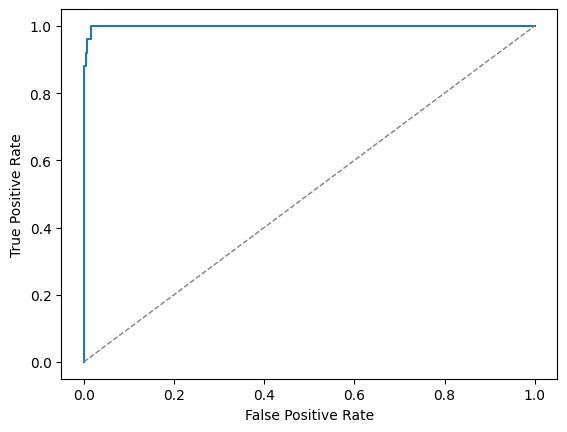

In [44]:
import random
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=50)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    NNmodel.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                epochs=3)
ROCplot(NNmodel,X,Y)

In [45]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,NNmodel.predict(x=X)))
confusion_matrix(pred,Y)

44/44 [==============================] - 0s 787us/step


array([[1374,    4],
       [   1,   21]])

In [46]:
NNmodel.predict(x=pd.DataFrame(X.iloc[1385]).transpose())


1/1 [==============================] - 0s 14ms/step


array([[0.91991514]], dtype=float32)

## Model test

In [47]:
X_test = pre_processed_test_data.drop(["id"],axis=1)
submition = pd.DataFrame()
submition["id"]=pre_processed_test_data["id"].to_numpy()
submition["generated"]=NNmodel.predict(x=X_test)
submition["generated"] = submition["generated"].apply(lambda x : round(x,2))
submition

1/1 [==============================] - 0s 15ms/step


,id,generated
0,0000aaaa,0.0
1,1111bbbb,0.0
2,2222cccc,0.0


In [48]:
submition.to_csv("../../data/submission.csv",index=False)